In [151]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from ast import literal_eval
from itertools import chain
from collections import Counter
from pprint import pprint
import string
from gensim.summarization import summarize
import langdetect
import re

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from nltk.corpus import stopwords

import spacy

# Pre-processing

Clean and reindex

In [152]:
# Import from medium and arxiv (all we have so far)
df_medium = pd.read_csv('../data/raw/medium_starter_pack.csv', compression='gzip')
df_arxiv = pd.read_pickle('../data/raw/arxiv_statsml_withbody_v2.pkl')
# Remove articles that have no tags (some are just comments), remove empty arxiv articles
df_medium = df_medium[df_medium.tags != '[]']
df_arxiv=df_arxiv[df_arxiv.body!='']
# Remove null values in tag and body field
df_medium = df_medium.dropna(subset=['tags'])
df_medium = df_medium.dropna(subset=['body'])
df_arxiv = df_arxiv.dropna(subset=['body'])
# Transform df.tags into list (they are strings)
df_medium.tags = df_medium.tags.apply(literal_eval)
# Remove articles below upvote threshold
upvotes_threshold = 10
df_medium = df_medium[df_medium.upvotes > upvotes_threshold]
# Detect language, throw away non-english
def try_langdetect(text):
    try:
        return langdetect.detect(text)      
    except:
        pass
df['language'] = df.body.apply(lambda x:try_langdetect(x))
df = df[df.language == 'en']



In [ ]:
# Sometimes there are errors if the text does not meet gensim's requirements - have it skip and move on
def try_summarize(text, word_count):
    try:
        return summarize(text, word_count = word_count)
    except ValueError:
        pass
# Make column of summaries for each article    
df_medium['summary'] = df_medium.body.apply(lambda x: try_summarize(x, word_count = words_body_threshold))
df_arxiv['summary'] = df_arxiv.body.apply(lambda x: try_summarize(x, word_count = words_body_threshold))

In [153]:
# For now, label medium as "easy-ish" (30) and arxiv as "difficult" (90)
# We can adjust scale later
df_medium['difficulty_level'] = 30.0
df_arxiv['difficulty_level'] = 90.0
df_medium['source'] = 'medium'
df_arxiv['source'] = 'arxiv'

Concatenate medium and arxiv articles 

In [154]:
df = pd.concat([df_medium,df_arxiv])
df.reset_index(inplace=True, drop=True)

Calculate parameters used to assess difficulty

In [155]:
# Number of words in article body
df['n_words_body'] = df.body.apply(str.lower).apply(len)
# Remove articles with less than a certain number of words
words_body_threshold = 100
df = df[df.n_words_body > words_body_threshold]
# Get amount of unique words
df['n_unique_body'] = df.body.apply(set).apply(len)
# Ratio of unique-to-total words
df['body_unique_ratio'] = df['n_unique_body']/df['n_words_body']
# Ratio of characters which are not letters, numbers, or punctuation
df['math_sym_ratio'] = df.body.apply(lambda x: sum(not c.isalpha() and not c.isdigit() and not c.isspace() 
                                                   and c not in string.punctuation for c in x)/len(x))


In [156]:
# Assess reading level.  MAY TAKE >15 MIN TO RUN.
from textstat.textstat import textstat
df['reading_grade_level'] = df.body.apply(lambda x: float(textstat.text_standard(x, float_output=True)))

Add a summary to each article

In [81]:
df.head(5)

,Unnamed: 0,abstract,author_name,author_url,authors,body,categories,content_type,created,difficulty_level,...,title,updated,upvotes,url,n_words_body,n_unique_body,body_unique_ratio,math_sym_ratio,reading_grade_level,language
0,0,"While at university, I joined Shazam as part t...",Umar Hansa,https://medium.freecodecamp.org/@umaar,NaN,"While at university, I joined Shazam as part t...",NaN,article,NaN,30.0,...,Data Visualisation with 1 Billion Shazam Music...,NaN,975.0,https://medium.freecodecamp.org/data-visualisa...,6476,66,0.010191,0.002625,9.0,en
1,1,Since I dived into data visualisation I’ve lea...,Ana,https://hackernoon.com/@eyeofdata,NaN,Since I dived into data visualisation I’ve lea...,NaN,article,NaN,30.0,...,What data visualisation has taught me so far –...,NaN,1300.0,https://hackernoon.com/what-data-visualisation...,5763,63,0.010932,0.007461,11.0,en
2,3,The trends of data visualisation are forever s...,Christian Thumer,https://medium.com/@christian_thumer,NaN,The trends of data visualisation are forever s...,NaN,article,NaN,30.0,...,Data visualisation: what’s next? – Signal Nois...,NaN,170.0,https://medium.com/signal-noise/data-visualisa...,12575,66,0.005249,0.003101,11.0,en
3,4,A boatload of visualisation tools and fancy da...,Ganes Kesari,https://towardsdatascience.com/@kesari,NaN,Inspite of the tremendous promise of data visu...,NaN,article,NaN,30.0,...,6 Reasons why Data Visualisation projects Fail...,NaN,364.0,https://towardsdatascience.com/6-reasons-why-d...,8148,68,0.008346,0.003191,12.0,en
4,5,This is the third part of Twitter sentiment an...,The Rickest Ricky,https://towardsdatascience.com/@rickykim78,NaN,This is the third part of Twitter sentiment an...,NaN,article,NaN,30.0,...,Another Twitter sentiment analysis with Python...,NaN,415.0,https://towardsdatascience.com/another-twitter...,10670,73,0.006842,0.007123,11.0,en


Save the preprocessed dataframe

In [ ]:
# Save so we don't have to re-run the preprocessing every time
df.to_csv("../data/raw/difficulty_regression_preprocess.csv")


## If you've preprocessed the data before, you can start here

...and read-in the preprocessed dataframe.

In [76]:
# Read in the preprocessed data frame if you've done this before
df = pd.read_csv("../data/raw/difficulty_regression_preprocess.csv")

# Create pipeline of TF-IDF and difficulty level analysis

Current difficulty-analysis techniques:
    - total number of words
    - ratio of number of unique words to total number of words
    - reading "age" assessment
    - percentage of characters which are not letters, numbers, or punctuation


In [19]:
#classes to make sure pipeline grabs values correctly
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [128]:
# Pipeline of tf-idf and difficulty analysis to be sent to the regression algorithms

# Preprocessor for tf-idf to remove numbers
def no_number_preprocessor(tokens):
    # This replaces it with 'NUM'
    #r = re.sub('(\d)+', 'NUM', tokens.lower())
    # This alternative just removes numbers:
    r = re.sub('(\d)+', '', tokens.lower())
    return r

text = Pipeline([
                ('selector', TextSelector(key='body')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=300, 
                                          stop_words='english', preprocessor=no_number_preprocessor))
            ])
body_word_length =  Pipeline([
                ('selector', NumberSelector(key='n_words_body')),
                ('standard', StandardScaler())
            ])
body_uniqueness_ratio =  Pipeline([
                ('selector', NumberSelector(key='body_unique_ratio')),
                ('standard', StandardScaler())
            ])
reading_difficulty =  Pipeline([
                ('selector', NumberSelector(key='reading_grade_level')),
                ('standard', StandardScaler())
            ])
unusual_sym_ratio =  Pipeline([
                ('selector', NumberSelector(key='math_sym_ratio')),
                ('standard', StandardScaler())
            ])


feats = FeatureUnion([
                      ('body', text),
                      ('n_words_body', body_word_length),
                      ('body_unique_ratio', body_uniqueness_ratio),
                      ('reading_grade_level', reading_difficulty),
                      ('math_sym_ratio', unusual_sym_ratio)
                     ])

In [129]:
# Split into train and test datasets
train_data, test_data = train_test_split(df, stratify=df.difficulty_level, test_size=0.2, random_state=42)

X_test = feats.fit_transform(test_data)
X_train = feats.transform(train_data)

y_test = test_data.difficulty_level.astype(float)
y_train = train_data.difficulty_level.astype(float)

## Classification/Regression

In [132]:
# Train the classifier/regressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 50, n_jobs = -1)
#regressor = LinearRegression(n_jobs = -1)
#regressor = KNeighborsRegressor(n_neighbors=2, weights='uniform', algorithm='auto', leaf_size=30,n_jobs = -1)
#regressor = AdaBoostRegressor(n_estimators=100, learning_rate=1.0, loss='linear', random_state=50)
#regressor = GradientBoostingRegressor()

# Use regressor to predict difficulty score
regressor.fit(X_train,y_train)
pred_test = regressor.predict(X_test)
pred_train = regressor.predict(X_train)

Take a look at the R^2 and standard deviation for several different regressors

In [131]:
#Gradient Boosting Regressor + removed numbers from features
print('train accuracy: ', np.mean(pred_train==y_train))
print('test accuracy: ', np.mean(pred_test==y_test))
print('mse: ', np.mean((pred_test-y_test)**2), ' out of possible score 100')
print('st dev: ', np.sqrt(np.mean((pred_test-y_test)**2)), ' out of possible score 100')
from sklearn.metrics import r2_score
print('r^2: ', r2_score(y_test, pred_test))

train accuracy:  0.0
test accuracy:  0.0
mse:  25.271791412826705  out of possible score 100
st dev:  5.027105669550492  out of possible score 100
r^2:  0.9718760936751749


In [127]:
#Gradient Boosting Regressor
print('train accuracy: ', np.mean(pred_train==y_train))
print('test accuracy: ', np.mean(pred_test==y_test))
print('mse: ', np.mean((pred_test-y_test)**2), ' out of possible score 100')
print('st dev: ', np.sqrt(np.mean((pred_test-y_test)**2)), ' out of possible score 100')
from sklearn.metrics import r2_score
print('r^2: ', r2_score(y_test, pred_test))

train accuracy:  0.0
test accuracy:  0.0
mse:  21.62958886479176  out of possible score 100
st dev:  4.6507621810614825  out of possible score 100
r^2:  0.9759293466323431


In [122]:
#Ada Boost Regressor
print('train accuracy: ', np.mean(pred_train==y_train))
print('test accuracy: ', np.mean(pred_test==y_test))
print('mse: ', np.mean((pred_test-y_test)**2), ' out of possible score 100')
print('st dev: ', np.sqrt(np.mean((pred_test-y_test)**2)), ' out of possible score 100')
from sklearn.metrics import r2_score
print('r^2: ', r2_score(y_test, pred_test))

train accuracy:  0.0
test accuracy:  0.0
mse:  67.58409441888345  out of possible score 100
st dev:  8.220954592921887  out of possible score 100
r^2:  0.9247885237166016


In [113]:
#knn Regressor
print('train accuracy: ', np.mean(pred_train==y_train))
print('test accuracy: ', np.mean(pred_test==y_test))
print('mse: ', np.mean((pred_test-y_test)**2), ' out of possible score 100')
print('st dev: ', np.sqrt(np.mean((pred_test-y_test)**2)), ' out of possible score 100')
from sklearn.metrics import r2_score
print('r^2: ', r2_score(y_test, pred_test))

train accuracy:  0.9867907535274693
test accuracy:  0.9813925570228091
mse:  37.81512605042017  out of possible score 100
st dev:  6.149400462680909  out of possible score 100
r^2:  0.9579171478060046


In [133]:
#Random Forest Regressor + remove numbers
print('train accuracy: ', np.mean(pred_train==y_train))
print('test accuracy: ', np.mean(pred_test==y_test))
print('mse: ', np.mean((pred_test-y_test)**2), ' out of possible score 100')
print('st dev: ', np.sqrt(np.mean((pred_test-y_test)**2)), ' out of possible score 100')
from sklearn.metrics import r2_score
print('r^2: ', r2_score(y_test, pred_test))

train accuracy:  0.903332332632843
test accuracy:  0.8595438175270108
mse:  27.283073229291738  out of possible score 100
st dev:  5.223320134674088  out of possible score 100
r^2:  0.9696378233256351


In [99]:
#Random Forest Regressor
print('train accuracy: ', np.mean(pred_train==y_train))
print('test accuracy: ', np.mean(pred_test==y_test))
print('mse: ', np.mean((pred_test-y_test)**2), ' out of possible score 100')
print('st dev: ', np.sqrt(np.mean((pred_test-y_test)**2)), ' out of possible score 100')
from sklearn.metrics import r2_score
print('r^2: ', r2_score(y_test, pred_test))

train accuracy:  0.9362053437406185
test accuracy:  0.9087635054021609
mse:  21.43145258103242  out of possible score 100
st dev:  4.629411688436493  out of possible score 100
r^2:  0.9761498441108545


## Let's take a look at what the regressor did

What is the distribution of predicted values?

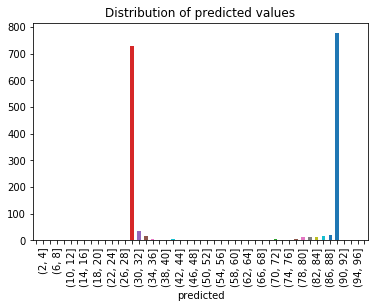

In [148]:
df_test = test_data[['source', 'title', 'tags']]
df_test["actual"] = y_test
df_test["predicted"] = pred_test

# Histogram of frequency of predicted values - pandas' series default plot is easier to read than mpl
bin_indx = np.arange(0,100,2)
df_test_plot = df_test.groupby(pd.cut(df_test["predicted"], bins=bin_indx)).predicted.count()
ax = df_test_plot.plot(kind='bar', title='Distribution of predicted values')
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


Print a table of articles in which the prediction was more than 1 standard devation away from the actual value.

In [137]:
incorrect = df_test[np.absolute(df_error["actual"] - df_test["predicted"]) > np.sqrt(np.mean((pred_test-y_test)**2))] 
print('number of articles with incorrect predictions:', len(incorrect), ' out of total articles ', len(test_data))
incorrect

number of articles with incorrect predictions: 83  out of total articles  1666


,source,title,tags,actual,predicted
5287,arxiv,deeparchitect: automatically designing and tra...,NaN,90.0,81.6
625,medium,News in AI and machine learning – Hacker Noon,"['machine learning', 'artificial intelligence'...",30.0,62.4
4276,arxiv,extreme stochastic variational inference: dist...,NaN,90.0,41.4
7842,arxiv,an interpretable latent variable model for att...,NaN,90.0,82.2
510,medium,Open Machine Learning Course. Topic 3. Classif...,"['machine learning', 'classification', 'decisi...",30.0,73.8
7687,arxiv,genetic algorithms for evolving computer chess...,NaN,90.0,79.2
6442,arxiv,data-driven tree transforms and metrics,NaN,90.0,76.2
6350,arxiv,beyond the technical challenges for deploying ...,NaN,90.0,69.6
6160,arxiv,a machine learning approach for evaluating cre...,NaN,90.0,82.2
2773,medium,Named Entity Recognition and Classification fo...,"['machine learning', 'nlp', 'named entity reco...",30.0,66.6


Summary of incorrect-ness, separated by source

In [138]:
incorrect_medium = incorrect[incorrect['source']=='medium']
incorrect_arxiv = incorrect[incorrect['source']=='arxiv']
print("Total test data = ", len(test_data) )
print("number incorrect medium = ", len(incorrect_medium) )
print("number incorrect arxiv = ", len(incorrect_arxiv) )
print('st dev medium: ', np.sqrt(np.mean((incorrect_medium.actual-incorrect_medium.predicted)**2)), ' out of possible score 100')
print('st dev arxiv: ', np.sqrt(np.mean((incorrect_arxiv.actual-incorrect_arxiv.predicted)**2)), ' out of possible score 100')

Total test data =  1666
number incorrect medium =  22
number incorrect arxiv =  61
st dev medium:  29.027510462255687  out of possible score 100
st dev arxiv:  20.747522072072787  out of possible score 100


Look at the tf-idf features that went into this

In [168]:
names_of_features = feats.transformer_list[0][1].steps[1][1]
names_of_features.get_feature_names()

['able',
 'accuracy',
 'adversarial',
 'ai',
 'al',
 'algorithm',
 'algorithms',
 'analysis',
 'applications',
 'applied',
 'approach',
 'approaches',
 'approximation',
 'arxiv',
 'assume',
 'assumption',
 'available',
 'average',
 'based',
 'bayesian',
 'best',
 'better',
 'bound',
 'bounds',
 'called',
 'case',
 'cases',
 'cid',
 'cid cid',
 'class',
 'classiﬁcation',
 'clustering',
 'code',
 'com',
 'compared',
 'complexity',
 'computational',
 'compute',
 'computer',
 'condition',
 'conference',
 'consider',
 'constant',
 'convergence',
 'convex',
 'convolutional',
 'corresponding',
 'cost',
 'data',
 'dataset',
 'datasets',
 'deep',
 'deep learning',
 'denote',
 'density',
 'detection',
 'deﬁne',
 'deﬁned',
 'deﬁnition',
 'different',
 'dimensional',
 'distance',
 'distribution',
 'distributions',
 'diﬀerent',
 'does',
 'end',
 'eq',
 'error',
 'estimate',
 'estimation',
 'estimator',
 'et',
 'et al',
 'example',
 'examples',
 'exp',
 'experiments',
 'fact',
 'feature',
 'features

In [193]:
def display_scores(vectorizer, tfidf_result):
    # http://stackoverflow.com/questions/16078015/
    
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    idf = vectorizer._tfidf.idf_
    return pd.DataFrame({'feature':vectorizer.get_feature_names(), 'score':idf})
        
tfidf_array = display_scores(names_of_features, names_of_features.idf_)

In [205]:
sorted_tfidf_array = tfidf_array.sort_values('score')
sorted_tfidf_array

,feature,score
48,data,1.186048
272,use,1.209441
275,using,1.242526
125,learning,1.246356
264,time,1.294303
273,used,1.309719
163,new,1.315459
289,work,1.316282
18,based,1.355733
139,machine,1.375621


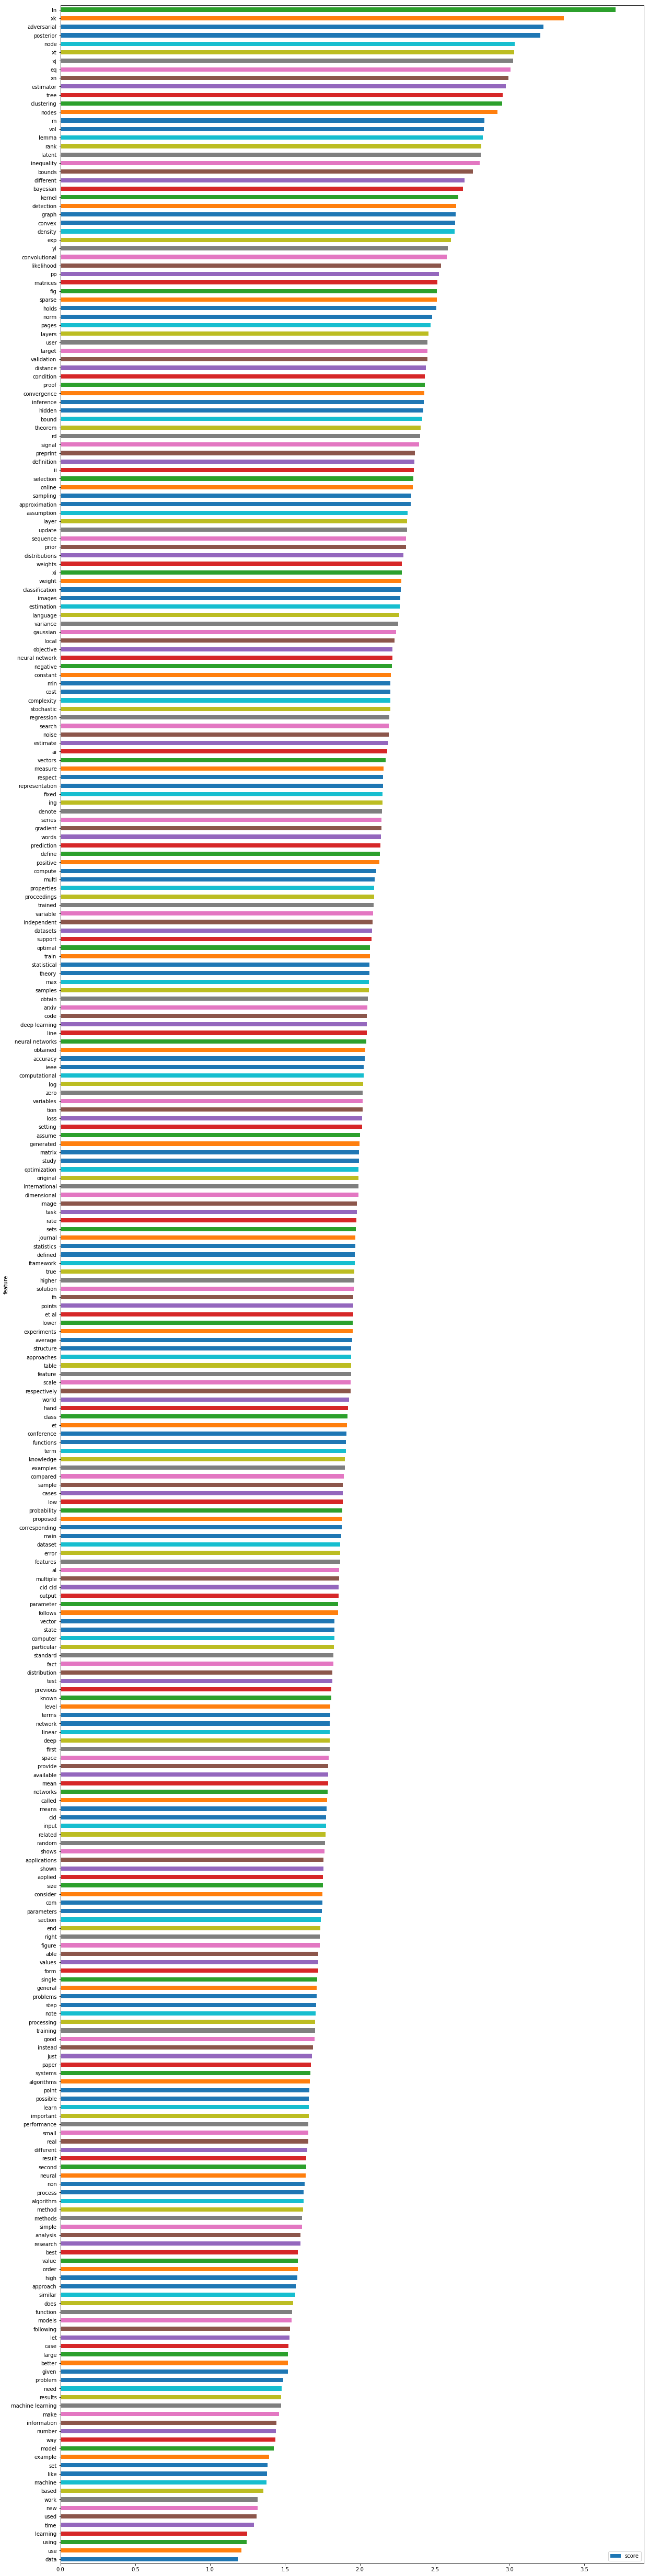

In [207]:
sorted_tfidf_array.plot.barh(x = 'feature', y='score', figsize=(20,90))